In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from glob import glob
from PIL import Image
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
import tensorflow as tf
from keras.preprocessing import image
from tensorflow. keras.utils import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn. model_selection import train_test_split
from keras.models import model_from_json
from tensorflow.keras.utils import to_categorical

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Generating a image

# Image resize

In [7]:
from PIL import Image
import numpy as np
import os


def resize_image(image_path, target_size=(299, 299)):
    img = Image.open(image_path)
    img = img.resize(target_size)  # Resize the image
    return np.array(img)


def load_and_resize_dataset(dataset_path, target_size):
    images = []
    labels = []
    class_names = os.listdir(dataset_path)
    
    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = resize_image(image_path, target_size)
            images.append(img)
            labels.append(class_names.index(class_name))
    
    return np.array(images), np.array(labels)


dataset_path = "C:\\Users\\stiev\\Internship Datamites Proj\\Data"  # Replace with your dataset path
target_size = (229, 229)  # Resize to 224x224
x, y = load_and_resize_dataset(dataset_path, target_size)


print(f"Resized images shape: {x.shape}")
print(f"Labels shape: {y.shape}")

Resized images shape: (120, 229, 229, 3)
Labels shape: (120,)


In [8]:

x = x.astype('float32') / 255.0

# parameters

In [9]:
data_dir = r"C:\\Users\\stiev\\Internship Datamites Proj\\Data" 
num_classes = 3
img_width, img_height = 299, 299
batch_size = 32
epochs = 50

# Load and Preprocess Images

In [10]:

def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))
    for class_name in class_names:
        class_path = os.path.join(folder, class_name)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_width, img_height))
            img = img.astype('float32') / 255.0
            images.append(img)
            labels.append(class_names.index(class_name))
    return np.array(images), np.array(labels)


X, y = load_images_from_folder(data_dir)

y = to_categorical(y, num_classes)

# Split Dataset

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Augmentation

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen.fit(X_train)

In [13]:
import tensorflow.keras.backend as K

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)  # Prevent log(0) errors
        ce = -y_true * K.log(y_pred)  # Cross-entropy loss
        weight = alpha * K.pow(1 - y_pred, gamma)  # Focusing factor
        return K.mean(weight * ce)  
    return loss

# VGG19 Model

In [14]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

base_model.trainable = False


x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile

In [15]:
model.compile(optimizer=Adam(learning_rate=0.000001), loss=focal_loss(alpha=0.25, gamma=2.0), metrics=['accuracy'])

# Callbacks

In [16]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoint = ModelCheckpoint('vgg19_rice_classifier.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

# Train the model

In [17]:

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=75,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.3524 - loss: 0.0938 
Epoch 1: val_accuracy improved from -inf to 0.41667, saving model to vgg19_rice_classifier.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 44s 15s/step - accuracy: 0.3529 - loss: 0.0914 - val_accuracy: 0.4167 - val_loss: 0.0477 - learning_rate: 1.0000e-06
Epoch 2/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2604 - loss: 0.0871 
Epoch 2: val_accuracy did not improve from 0.41667
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 14s/step - accuracy: 0.2500 - loss: 0.0868 - val_accuracy: 0.4167 - val_loss: 0.0439 - learning_rate: 1.0000e-06
Epoch 3/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2726 - loss: 0.0892 
Epoch 3: val_accuracy did not improve from 0.41667
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 14s/step - accuracy: 0.2799 - loss: 0.0877 - val_accuracy: 0.4167 - val_loss: 0.0411 - learning_rate: 1.0000e-06
Epoch 4/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3490 - loss: 0.0794 
Epoch 4: val_accuracy did not improve from 0.41667
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 14s/step - accuracy: 0.3477 - loss: 0.0781 - val_accuracy: 0.3750 - val_loss: 0.0393 - learning_rate: 1.0000e-06
Epoch 5/75
3/3 ━━━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 16s/step - accuracy: 0.2786 - loss: 0.0689 - val_accuracy: 0.5000 - val_loss: 0.0384 - learning_rate: 1.0000e-06
Epoch 7/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3819 - loss: 0.0527 
Epoch 7: val_accuracy improved from 0.50000 to 0.54167, saving model to vgg19_rice_classifier.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 15s/step - accuracy: 0.3854 - loss: 0.0528 - val_accuracy: 0.5417 - val_loss: 0.0388 - learning_rate: 1.0000e-06
Epoch 8/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.3333 - loss: 0.0695 
Epoch 8: val_accuracy did not improve from 0.54167
3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 15s/step - accuracy: 0.3281 - loss: 0.0697 - val_accuracy: 0.4167 - val_loss: 0.0393 - learning_rate: 1.0000e-06
Epoch 9/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.4288 - loss: 0.0516 
Epoch 9: val_accuracy did not improve from 0.54167
3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 15s/step - accuracy: 0.4284 - loss: 0.0527 - val_accuracy: 0.3750 - val_loss: 0.0400 - learning_rate: 1.0000e-06
Epoch 10/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3837 - loss: 0.0639 
Epoch 10: val_accuracy did not improve from 0.54167
3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 14s/step - accuracy: 0.3763 - loss: 0.0638 - val_accuracy: 0.3333 - val_loss: 0.0407 - learning_rate: 1.0000e-06
Epoch 11/75
3/3 ━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 15s/step - accuracy: 0.3060 - loss: 0.0653 - val_accuracy: 0.5833 - val_loss: 0.0310 - learning_rate: 1.0000e-06
Epoch 38/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3889 - loss: 0.0511 
Epoch 38: val_accuracy did not improve from 0.58333
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 13s/step - accuracy: 0.3958 - loss: 0.0507 - val_accuracy: 0.5833 - val_loss: 0.0306 - learning_rate: 1.0000e-06
Epoch 39/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4722 - loss: 0.0449 
Epoch 39: val_accuracy did not improve from 0.58333
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 13s/step - accuracy: 0.4661 - loss: 0.0458 - val_accuracy: 0.5833 - val_loss: 0.0302 - learning_rate: 1.0000e-06
Epoch 40/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4670 - loss: 0.0485  
Epoch 40: val_accuracy did not improve from 0.58333
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 13s/step - accuracy: 0.4544 - loss: 0.0488 - val_accuracy: 0.5833 - val_loss: 0.0301 - learning_rate: 1.0000e-06
Epoch 41/75
3/3 ━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 17s/step - accuracy: 0.5169 - loss: 0.0433 - val_accuracy: 0.6250 - val_loss: 0.0292 - learning_rate: 1.0000e-06
Epoch 47/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.4219 - loss: 0.0576 
Epoch 47: val_accuracy improved from 0.62500 to 0.66667, saving model to vgg19_rice_classifier.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 17s/step - accuracy: 0.4336 - loss: 0.0567 - val_accuracy: 0.6667 - val_loss: 0.0290 - learning_rate: 1.0000e-06
Epoch 48/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.4323 - loss: 0.0455 
Epoch 48: val_accuracy did not improve from 0.66667
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 16s/step - accuracy: 0.4180 - loss: 0.0468 - val_accuracy: 0.6667 - val_loss: 0.0288 - learning_rate: 1.0000e-06
Epoch 49/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.4392 - loss: 0.0506 
Epoch 49: val_accuracy did not improve from 0.66667
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 16s/step - accuracy: 0.4284 - loss: 0.0509 - val_accuracy: 0.6667 - val_loss: 0.0287 - learning_rate: 1.0000e-06
Epoch 50/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.4479 - loss: 0.0427 
Epoch 50: val_accuracy did not improve from 0.66667
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 16s/step - accuracy: 0.4453 - loss: 0.0432 - val_accuracy: 0.6667 - val_loss: 0.0285 - learning_rate: 1.0000e-06
Epoch 51/75
3/3 ━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 17s/step - accuracy: 0.4922 - loss: 0.0487 - val_accuracy: 0.7083 - val_loss: 0.0263 - learning_rate: 1.0000e-06
Epoch 60/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.4132 - loss: 0.0530 
Epoch 60: val_accuracy did not improve from 0.70833
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 16s/step - accuracy: 0.4167 - loss: 0.0529 - val_accuracy: 0.7083 - val_loss: 0.0262 - learning_rate: 1.0000e-06
Epoch 61/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.3941 - loss: 0.0555 
Epoch 61: val_accuracy did not improve from 0.70833
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 16s/step - accuracy: 0.3919 - loss: 0.0557 - val_accuracy: 0.7083 - val_loss: 0.0260 - learning_rate: 1.0000e-06
Epoch 62/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.4097 - loss: 0.0437 
Epoch 62: val_accuracy did not improve from 0.70833
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 16s/step - accuracy: 0.4115 - loss: 0.0447 - val_accuracy: 0.7083 - val_loss: 0.0260 - learning_rate: 1.0000e-06
Epoch 63/75
3/3 ━━━━━━━━

# Evaluate the model

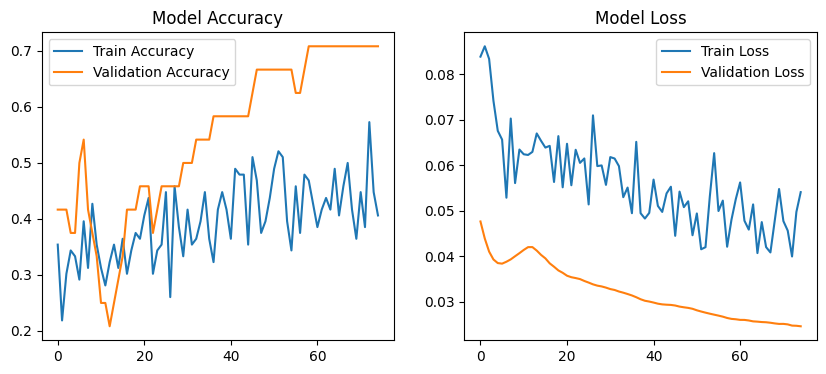

In [18]:
plt.figure(figsize=(10, 4))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")

plt.show()

In [19]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model


def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)  # Prevent log(0) errors
        ce = -y_true * K.log(y_pred)  # Cross-entropy loss
        weight = alpha * K.pow(1 - y_pred, gamma)  # Focusing factor
        return K.mean(weight * ce)  
    return loss


custom_objects = {"loss": focal_loss(alpha=0.25, gamma=2.0)}
model = load_model("vgg19_rice_classifier.h5", custom_objects=custom_objects)

In [20]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.7083 - loss: 0.0263
Test accuracy: 0.71


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


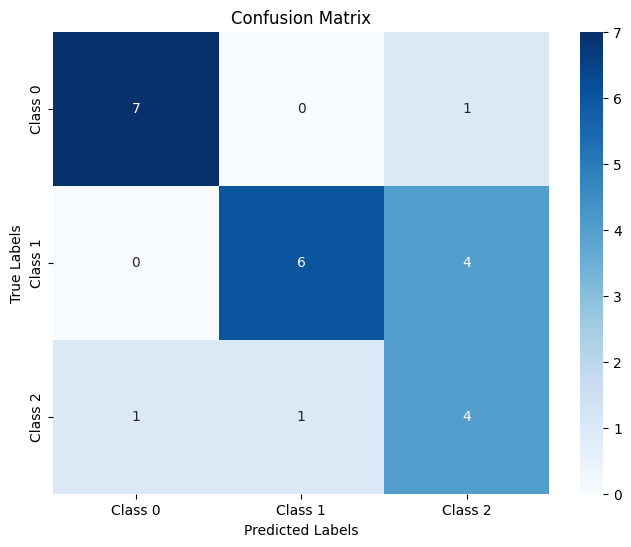

In [21]:

from sklearn.metrics import confusion_matrix
# from tensorflow.keras.models import load_mode
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

report = classification_report(y_true_classes, y_pred_classes, target_names=['Class 0', 'Class 1', 'Class 2'])
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
              precision    recall  f1-score   support

     Class 0       0.88      0.88      0.88         8
     Class 1       0.86      0.60      0.71        10
     Class 2       0.44      0.67      0.53         6

    accuracy                           0.71        24
   macro avg       0.73      0.71      0.70        24
weighted avg       0.76      0.71      0.72        24



# Save the model

In [33]:
model.save('vgg19_rice_classifier.h5')